In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

# KL Divergence
# Noise for variational autoencoder
# larger training set

### Data & Model Parameters

In [3]:
smiles = list(fetch_smiles_gdb13('./data/gdb13/')[0])

In [4]:
params = make_params(smiles=smiles, GRU_HIDDEN_DIM=256, LATENT_DIM=128, to_file='gdb13_params.json')
#params = make_params(from_file='gdb13_params.json')

In [4]:
total_n = 100000
train_n = 100000
test_n = total_n - train_n

one_hots = to_one_hot(random.sample(smiles, total_n), params)

train_dataloader = DataLoader(one_hots[:train_n], batch_size=32, shuffle=True)
#test_dataloader = DataLoader(one_hots[train_n:], batch_size=5, shuffle=True)

print(f'total_n = {total_n}')
print(f'train_n = {train_n}')
print(f'test_n = {test_n}')

total_n = 100000
train_n = 100000
test_n = 0


### Model

In [5]:
encoder = Encoder(params)
decoder = Decoder(params)

In [6]:
encoder.load_state_dict(torch.load('encoder_weights.pth'))
decoder.load_state_dict(torch.load('decoder_weights.pth'))

<All keys matched successfully>

### Train

In [7]:
LR = 0.0001
EPOCHS = 3

In [8]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LR)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

losses = []

encoder.train()
decoder.train()

for epoch_n in range(EPOCHS):
    for x in train_dataloader:
        
        # x.shape = (N, L, C)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        latents = encoder(x)
        
        y = decoder(latents, target=x)
        
        loss = criterion(y.transpose(1, 2), torch.argmax(x, dim=2))

        losses.append(float(loss))
        
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
torch.save(encoder.state_dict(), 'encoder_weights.pth')
torch.save(decoder.state_dict(), 'decoder_weights.pth')

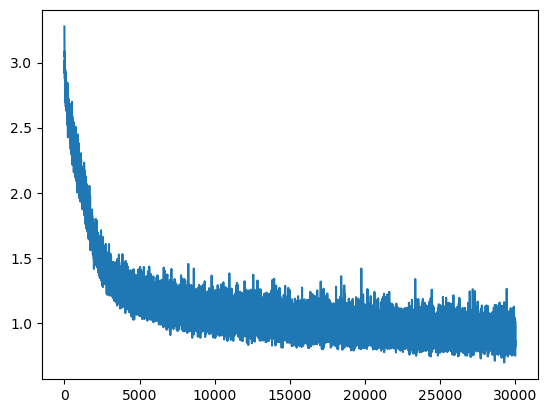

In [9]:
plt.plot(losses)

## Test

In [7]:
evaluate_ae(encoder, decoder, smiles, 1000, params=params)

mean token matching: 0.3323749899864197

['C1C2CC34CCOC(CN13)C4C[NH2+]2', 'OC12CCC3(C1)CC(CCO3)OC2', 'C1OCC23C[NH2+]C4CC2CC4CC13', 'C1CC2C3COC4C(C[NH+]2C14)N3', 'OC1C2CCC1C1=NSC=C1N2', 'C1CC2C[NH2+]C1CC1=C2NC=C1', 'C1OC2C3COC4C3[NH2+]C1C24', 'NC1=CSC(=C1)N1CCNC1=S', 'OC1=CNC2=NC3=C(C=CS3)N12', 'OC1CCC2C3CCC4C3C[NH+]2C14']
['CN1OC1=O1)=C', 'OC=CCN21', 'C21CCOOCCCOC2', 'CNC2+]2', 'OCCCCCCCCCCCCCCC2CCCCCCC2)N1)CH2CC', 'C1O33OONOOOOCC3NCN3=N3ONCN', 'C1NC', 'N2222CCCCCCCOCCOCCCN', 'O=CCCCCC', 'O2(CCCCCCCCOOOC[NCCNCOCCCCCNCCC2CCCCCH']


In [8]:
smiles = random.sample(smiles, 1000)

one_hots = to_one_hot(smiles, params)

latents = encoder(one_hots)

y = decoder(latents)

In [14]:
smiles[1]

'OC1=CC2=C(CCOCCC2)N1'

In [12]:
from_one_hot(torch.softmax(y, dim=2), params)

['SC11CCCCCCCCC1CCCCC1N12COC1=CCCOC',
 'OC(=CCCCCOOCC2CCCCOON31C1CCC1CCC',
 'O22H2C2C',
 'C122=O',
 'O=CCCCC1)N12CCCOC]',
 'O22222CCCCCNCCO2',
 'C1NCCCC121]C1C',
 'C1CC11CCCN3O3OO1ON123CCCOC)1=CC',
 'CCC1CC)]COC',
 'O=C=1CC',
 'C1CCOONCC12CCOO]112)CC',
 'O=CCC1C)CCOCC11CCC3',
 'C1CCOONNC3COCCC3CN]C)22)N',
 'C11CCOCOCCCN1',
 'OCC=CNC1',
 '==CCC]1)CCCCCO=',
 'OC=C==CCCCC=CCCCCCCC=)',
 'OC)OCCC',
 'CCCCCCCCC=CCCO1CC1COC',
 'O=C1C1OOC1OOO14CCOO)N12CCCOC1CCCC1',
 'C1CC2OOON21ONOC',
 '1CCCCC',
 'C1CCCCCCCCC2NC1',
 'OCCCO',
 '[N2H2]2]2O2OCCONCCCCC221',
 'CCCCCC1C',
 'OCCCC=C2CCCCCCOCCCOC)C11',
 'C1CCCC222CCO2',
 '[N2]222',
 'OC11CCCOCCO2C2CCCCOC1CC',
 'NC2CCCCCCOC1OS3CCCC1C1CCCCNC',
 'COCC22COC21=C1ONCN1OCC',
 '[N]]H]]]]',
 'C1O2CCCO2O1222COO',
 'COO221OCCON22C1O11',
 'O=CCC=CCCC',
 'C1O222CCOOCCC1',
 'O=CCCCCCCCCCCCCCC1CC',
 '[N]]]]2',
 'OC1CC21O=CCCCC',
 '[N]]]]]22',
 'O=C1CCCCOOC',
 'C1CCOCCCNCO]2',
 'C2C22',
 'C1CCC1CCCCNC22CCOCCC=COC',
 'OC=CCC',
 'CCCCCC1C21CCC',
 '[NH2H2]2CCC32',
 '=CC